In [98]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import ConvexHull
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv(r"starman.csv")
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,O
236,30839,834042.000000,1194.0000,-10.63,5,Blue,O
237,8829,537493.000000,1423.0000,-10.73,5,White,A
238,9235,404940.000000,1112.0000,-11.23,5,White,A


In [112]:
df = pd.read_csv(r"starman.csv")

testBin = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
data_discrete = testBin.fit_transform(df.values[:,[0,1,2,3,4]])
df[['Temperature (K)','Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']] = data_discrete


df[['Star color', 'Spectral Class']] = df[['Star color', 'Spectral Class']].apply(LabelEncoder().fit_transform)
df.loc[:,:] = df.loc[:,:].astype('int')
k = df["Star color"].unique()
k.sort()
print(k)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


C:\Users\rosen\AppData\Local\Temp\ipykernel_5508\2848968467.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,:] = df.loc[:,:].astype('int')


In [105]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop("Star type", axis=1), df["Star type"], test_size=0.2)
X_train

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color,Spectral Class
51,2,4,4,0,10,5
117,2,3,4,0,10,5
80,2,0,0,3,12,2
151,2,2,2,2,5,0
142,4,1,0,3,0,1
...,...,...,...,...,...,...
104,3,3,3,1,0,6
81,3,0,0,3,11,2
66,0,0,1,4,10,5
169,3,4,3,1,0,6


In [106]:
class KnnClassifier:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X_train, y_train):
        self.X_train = X_train.values
        self.y_train = y_train.values
        return self
        
    def predict(self, X):
        predicts = []
        X_train = self.X_train
        for sample in X.iterrows():
            sample = sample[1].values
            dists = (((self.X_train - sample)**2).sum(axis=1))**0.5
            dists = dists.tolist()
            idxes = []
            for _ in range(self.k):
                idx = np.argmin(dists)
                idxes.append(idx)
                del dists[idx]
            count = Counter(self.y_train[idxes].tolist())
            p = max(count, key=count.get)
            predicts.append(p)
        return np.array(predicts)

In [113]:
clf = KnnClassifier(k=2).fit(X_train, y_train)
al = (clf.predict(X_valid) == y_valid).mean()
al.round(2)

0.96

D:\1\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


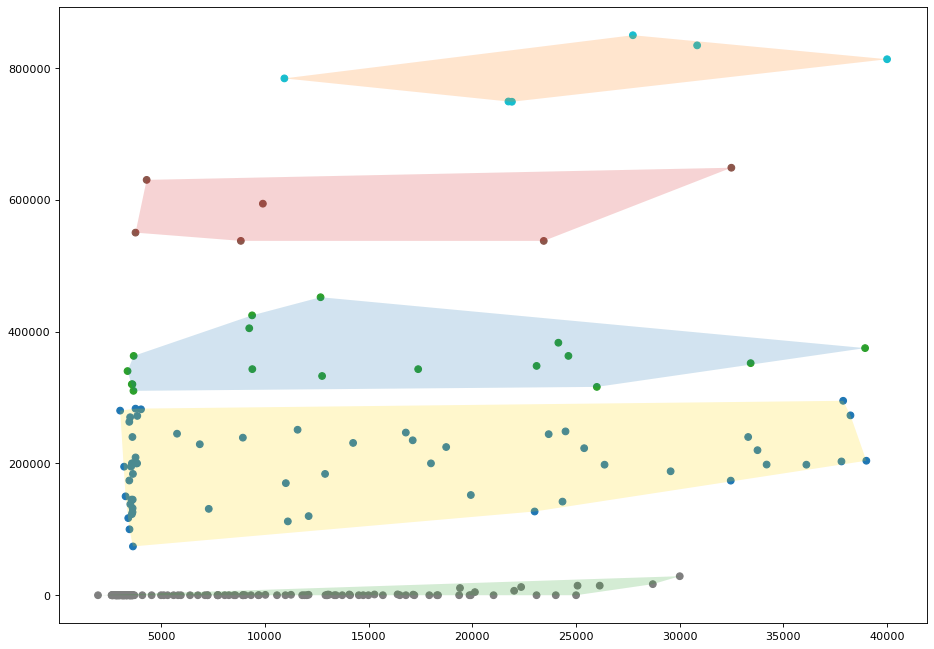

In [102]:
#visual 1


cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df[['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']])  

plt.figure(figsize=(14, 10), dpi= 80)  
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=cluster.labels_, cmap='tab10')

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)
    
encircle(df.loc[cluster.labels_ == 0, 'Temperature (K)'], df.loc[cluster.labels_ == 0, 'Luminosity(L/Lo)'], ec="k", fc="gold", alpha=0.2, linewidth=0)
encircle(df.loc[cluster.labels_ == 1, 'Temperature (K)'], df.loc[cluster.labels_ == 1, 'Luminosity(L/Lo)'], ec="k", fc="tab:blue", alpha=0.2, linewidth=0)
encircle(df.loc[cluster.labels_ == 2, 'Temperature (K)'], df.loc[cluster.labels_ == 2, 'Luminosity(L/Lo)'], ec="k", fc="tab:red", alpha=0.2, linewidth=0)
encircle(df.loc[cluster.labels_ == 3, 'Temperature (K)'], df.loc[cluster.labels_ == 3, 'Luminosity(L/Lo)'], ec="k", fc="tab:green", alpha=0.2, linewidth=0)
encircle(df.loc[cluster.labels_ == 4, 'Temperature (K)'], df.loc[cluster.labels_ == 4, 'Luminosity(L/Lo)'], ec="k", fc="tab:orange", alpha=0.2, linewidth=0)

In [ ]:
#visual 2

